# ANES

Intro...

[Ryan Burge has done a similar analysis]() with data from the [Cooperative Election Study](https://cces.gov.harvard.edu/) (CSE)...


Citation:

American National Election Studies. 2024. ANES 2024 Pilot Study [dataset and documentation].
March 19, 2024 version. www.electionstudies.org

In [1]:
%load_ext nb_black
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ProbablyOverthinkingIt/blob/book/examples/anes_2024_pilot.ipynb) -- but you will have to download the data yourself, because I am not allowed to redistribute it.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>

In [166]:
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.figsize"] = [6, 3.5]

<IPython.core.display.Javascript object>

In [167]:
aibm_light_gray = "#F3F4F3"
aibm_medium_gray = "#767676"
aibm_green = "#0B8569"
light_green = "#AAC9B8"
aibm_orange = "#C55300"
light_orange = "#F4A26B"
aibm_purple = "#9657A5"
light_purple = "#CFBCD0"
aibm_blue = "#4575D6"
light_blue = "#C9D3E8"

<IPython.core.display.Javascript object>

In [4]:
from statsmodels.nonparametric.smoothers_lowess import lowess


def make_lowess(series, frac=0.5):
    """Use LOWESS to compute a smooth line.

    series: pd.Series

    returns: pd.Series
    """
    y = series.values
    x = series.index.values

    smooth = lowess(y, x, frac=frac)
    index, data = np.transpose(smooth)

    return pd.Series(data, index=index)

<IPython.core.display.Javascript object>

In [5]:
def plot_series_lowess(series, color, plot_series=True, frac=0.5, **options):
    """Plots a series of data points and a smooth line.

    series: pd.Series
    color: string or tuple
    """
    if "label" not in options:
        options["label"] = series.name

    if plot_series or len(series) == 1:
        x = series.index
        y = series.values
        plt.plot(x, y, "o", color=color, alpha=0.3, label="_")

    if not plot_series and len(series) == 1:
        x = series.index
        y = series.values
        plt.plot(x, y, "o", color=color, alpha=0.6, label=options["label"])

    if len(series) > 1:
        smooth = make_lowess(series, frac=frac)
        smooth.plot(color=color, **options)

<IPython.core.display.Javascript object>

In [6]:
def decorate(**options):
    """Decorate the current axes.

    Call decorate with keyword arguments like
    decorate(title='Title',
             xlabel='x',
             ylabel='y')

    The keyword arguments can be any of the axis properties
    https://matplotlib.org/api/axes_api.html
    """
    ax = plt.gca()
    ax.set(**options)

    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles, labels)

    plt.tight_layout()

<IPython.core.display.Javascript object>

In [7]:
def values(series):
    return series.value_counts(dropna=False).sort_index()

<IPython.core.display.Javascript object>

In [8]:
def savefig(filename, **options):
    if "dpi" not in options:
        options["dpi"] = 300
    plt.savefig(filename, **options)

<IPython.core.display.Javascript object>

In [9]:
from utils import underride


def value_counts(series, **options):
    """Make a series of values and the number of times they appear.

    Returns a DataFrame because they get rendered better in Jupyter.

    series: Pandas Series

    returns: Pandas DataFrame
    """
    options = underride(options, dropna=False)
    series = series.value_counts(**options).sort_index()
    series.index.name = "values"
    series.name = "counts"
    return pd.DataFrame(series)

<IPython.core.display.Javascript object>

## Read the Data

[You can get the data here](https://electionstudies.org/data-center/2024-pilot-study/) -- but you'll need to create an account.

We drop the cases that have invalid weights:

> There are 1,500 weighted cases on the file and an additional 409 unweighted cases not
intended for population inference. The weighted cases are intended to represent the
population. The 1,500 weighted cases completed the questionnaire, passed a quality control
check by YouGov, and were selected using the sample matching procedure described below in
the Sampling and Weighting section. The additional 409 cases are described below and include
296 partial interviews and 113 people who completed the questionnaire but were not selected
using the sample matching procedure. The additional cases are included to allow
methodological analysis, such as a review of the randomization used in question wording
experiments. Weights are not provided for the additional 409 cases, as they are not intended to
contribute to population inference. The unmatched cases can be distinguished from the main
cases by their missing weights in the weight variable or using the variable sample_type.

Recommended description from the codebook:

> “The survey was conducted using non-probability sampling. This method produces a
sample that looks similar to a probability sample on the matched characteristics but may
still differ in unknown ways on unmatched characteristics.”


In [209]:
filename = "anes_pilot_2024_20240319.dta"
df = pd.read_stata(filename, convert_categoricals=False).dropna(subset=["weight"])
df.shape

(1500, 941)

<IPython.core.display.Javascript object>

In [33]:
value_counts(df["gender"])

,counts
values,
1.0,725
2.0,775


<IPython.core.display.Javascript object>

In [34]:
df["age"] = df["age"].replace(-9, np.nan)
value_counts(df["age"])

,counts
values,
18.0,7
19.0,11
20.0,43
21.0,23
22.0,31
...,...
85.0,4
86.0,1
88.0,2


<IPython.core.display.Javascript object>

In [35]:
df["weight"].describe()

count    1500.000000
mean        1.000000
std         0.468987
min         0.314350
25%         0.718226
50%         0.894765
75%         1.130104
max         7.000960
Name: weight, dtype: float64

<IPython.core.display.Javascript object>

In [36]:
varname = "follow_campinterest"
value_counts(df[varname])

,counts
values,
1.0,635
2.0,547
3.0,318


<IPython.core.display.Javascript object>

In [76]:
from scipy.stats import norm


def estimate_proportion(success_series, weights_series, confidence_level=0.9):
    """
    Calculate the weighted proportion and Wilson score interval for weighted data.

    Parameters:
    success_series (pd.Series): A boolean series where True represents a success.
    weights_series (pd.Series): A series of weights corresponding to the success_series.
    confidence_level (float): The confidence level for the Wilson score interval

    Returns:
    weighted_proportion (float): The weighted proportion of successes.
    lower: The lower and upper bounds of the Wilson score interval.
    """
    # Ensure the series are aligned and of correct type
    success_series = success_series.astype(float)
    weights_series = weights_series.astype(float)

    # Calculate weighted proportion
    total_weight = weights_series.sum()
    weighted_successes = (success_series * weights_series).sum()
    p = weighted_successes / total_weight

    # Calculate the z-score for the given confidence level
    z = norm.ppf(1 - (1 - confidence_level) / 2)

    # Wilson score interval adjusted for weighted data
    denominator = 1 + z**2 / total_weight
    center = (p + z**2 / (2 * total_weight)) / denominator
    sd = (
        np.sqrt((p * (1 - p) + z**2 / (4 * total_weight)) / total_weight)
        / denominator
    )

    # Lower and upper bounds of the Wilson interval
    lower = center - z * sd
    upper = center + z * sd

    return p, lower, upper

<IPython.core.display.Javascript object>

In [40]:
estimate_proportion(df["follow_campinterest"] == 1, df["weight"])

1.6448536269514722


(0.4111023206163364, 0.39038394040705343, 0.43214081215493266)

<IPython.core.display.Javascript object>

About party identification, respondents were randomly asked two versions of the question, with the parties in different orders.
We'll combine the results into a single column, and lump other party with independent.

In [41]:
pid1d = df["pid_pid1d"].replace([-1, 5], [np.nan, 3])
pid1r = df["pid_pid1r"].replace([-1, 1, 2, 5], [np.nan, 2, 1, 3])

df["pid"] = pid1d.fillna(pid1r)
value_counts(df["pid"])

,counts
values,
1.0,528
2.0,434
3.0,538


<IPython.core.display.Javascript object>

From the sample, select male and female respondents.

In [43]:
df_male = df.query("gender == 1")
df_female = df.query("gender == 2")

<IPython.core.display.Javascript object>

## How important

This section explores answers to several questions of the form, "How important are each of the following issues in the country today?"

```
1. Extremely important
2. Very important
3. Moderately important
4. Slightly important
5. Not at all important
```

In [44]:
def find_columns(df, prefix):
    return [
        col
        for col in df.columns
        if col.startswith(prefix)
        and not col.endswith("skp")
        and not col.endswith("timing")
    ]

<IPython.core.display.Javascript object>

In [45]:
columns = find_columns(df, "imp_")
columns

['imp_immig',
 'imp_jobs',
 'imp_costliv',
 'imp_climate',
 'imp_abort',
 'imp_gun',
 'imp_crime',
 'imp_gaza',
 'imp_antisem',
 'imp_votright',
 'imp_ukraine',
 'imp_schteach',
 'imp_islamop']

<IPython.core.display.Javascript object>

Here are the functions we'll use to measure and plot gender differences in the responses.

In [182]:
def value_count_frame(data, columns, normalize=False):
    """Value counts for each column.

    Returns: DataFrame with one row per value, one column per variable
    """
    return pd.DataFrame(
        {col: data[col].value_counts(normalize=normalize) for col in columns}
    ).fillna(0)

<IPython.core.display.Javascript object>

In [183]:
issue_names = {
    "imp_immig": "Illegal immigration",
    "imp_jobs": "Jobs/employment",
    "imp_costliv": "Cost of living and\nrising prices",
    "imp_climate": "Climate change",
    "imp_abort": "Abortion",
    "imp_gun": "Gun policy",
    "imp_crime": "Crime",
    "imp_gaza": "War in Gaza",
    "imp_antisem": "Antisemitism",
    "imp_votright": "Voting rights",
    "imp_ukraine": "War in Ukraine",
    "imp_schteach": "What’s taught in\npublic schools",
    "imp_islamop": "Anti-Muslim bias",
}

<IPython.core.display.Javascript object>

In [184]:
columns = issue_names.keys()
counts = value_count_frame(df, columns, normalize=True)
counts

,imp_immig,imp_jobs,imp_costliv,imp_climate,imp_abort,imp_gun,imp_crime,imp_gaza,imp_antisem,imp_votright,imp_ukraine,imp_schteach,imp_islamop
-7.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001379,0.000000,0.001379,0.000000,0.000000
1.0,0.482759,0.437241,0.612414,0.324138,0.299310,0.376552,0.451034,0.212414,0.194483,0.433103,0.220690,0.431724,0.147586
2.0,0.217931,0.340690,0.251034,0.183448,0.264828,0.293793,0.286897,0.234483,0.285517,0.273103,0.244138,0.284138,0.169655
3.0,0.166897,0.175172,0.111724,0.150345,0.206897,0.173793,0.188966,0.280000,0.271724,0.173793,0.252414,0.188966,0.251034
4.0,0.088276,0.034483,0.017931,0.111724,0.114483,0.077241,0.066207,0.142069,0.126897,0.060690,0.140690,0.053793,0.175172
5.0,0.044138,0.012414,0.006897,0.230345,0.114483,0.078621,0.006897,0.131034,0.120000,0.059310,0.140690,0.041379,0.256552


<IPython.core.display.Javascript object>

In [185]:
value_map = {"important": [1, 2], "not/slightly": [4, 5]}

<IPython.core.display.Javascript object>

In [186]:
def estimate_column(df, columns, values):
    res = pd.DataFrame(index=columns, columns=["p", "low", "high"])
    data = df[columns].replace(-7, np.nan)
    data["weight"] = df["weight"]

    for column in columns:
        subset = data.dropna(subset=column)
        series = subset[column].isin(values)
        weight = subset["weight"]
        res.loc[column] = estimate_proportion(series, weight)

    return res * 100

<IPython.core.display.Javascript object>

In [187]:
def estimate_value_map(df, columns, value_map):
    keys = list(value_map.keys())
    dfs = [estimate_column(df, columns, values) for values in value_map.values()]
    return pd.concat(dfs, axis=1, keys=keys)

<IPython.core.display.Javascript object>

In [188]:
def estimate_gender_map(df, columns, gender_map, value_map):
    keys = list(gender_map.keys())
    dfs = [estimate_value_map(df, columns, value_map) for df in gender_map.values()]
    return pd.concat(dfs, axis=1, keys=keys)

<IPython.core.display.Javascript object>

In [189]:
gender_map = dict(male=df_male, female=df_female)
summary = estimate_gender_map(df, columns, gender_map, value_map).sort_values(
    by=("female", "important", "p")
)
summary

male                                                \
              important                       not/slightly              
                      p        low       high            p        low   
imp_islamop   32.705209  29.913851  35.624641     42.14601  39.170239   
imp_ukraine    46.30623  43.283243  49.356616    28.683145  26.006692   
imp_gaza      45.870176  42.853345  48.917591    28.166181  25.508759   
imp_antisem   46.959682  43.932983  50.008912    25.253875  22.699303   
imp_climate    52.41577  49.367885  55.445766    32.136862  29.360545   
imp_immig     69.340944  66.462777  72.075886    14.338622  12.334007   
imp_abort     56.314776  53.273185  59.309603     22.80171  20.347463   
imp_gun       66.706498  63.776352  69.512927    14.922145  12.880028   
imp_votright  70.890521  68.047891   73.57845    13.230942  11.300847   
imp_crime     72.344411  69.538647  74.984706     7.765722   6.286084   
imp_schteach  70.353055  67.497668  73.057721     10.63733   8.901341   
imp_jobs      78.091836  75.468786  80.506856      4.93002   3.769013   
imp_costliv   86.538082  84.321495  88.484092     2.689951   1.865177   

                            female                                     \
                         important                       not/slightly   
                   high          p        low       high            p   
imp_islamop   45.179943   35.33781  32.562702    38.2154    32.014469   
imp_ukraine   31.517715  46.031117  43.099474  48.990481    26.974403   
imp_gaza      30.985291   46.29428  43.360525  49.253918    23.309554   
imp_antisem   27.991833  50.733583  47.776543  53.685498    21.092111   
imp_climate   35.045462  52.725478  49.765543  55.666377    28.714676   
imp_immig     16.607322  66.622545  63.777162  69.351826    13.877366   
imp_abort     25.457369  67.215285  64.380381  69.929946    15.279361   
imp_gun       17.224025  69.997314  67.218393   72.63656    10.610941   
imp_votright  15.433324  72.617129  69.901743  75.174543     9.599584   
imp_crime      9.558119  76.255124  73.647116  78.679749     6.038215   
imp_schteach  12.664813   76.61001  74.013769  79.020388      7.53107   
imp_jobs       6.424785  79.291431  76.792283  81.585989     4.014777   
imp_costliv    3.865073  89.340846  87.374628  91.032282     1.438509   

                                    
                                    
                    low       high  
imp_islamop    29.31863  34.836018  
imp_ukraine    24.43075  29.678882  
imp_gaza      20.902438  25.903093  
imp_antisem   18.780063   23.60607  
imp_climate   26.114299  31.463724  
imp_immig     11.956621  16.050414  
imp_abort      13.27096  17.530273  
imp_gun        8.923288  12.573712  
imp_votright   7.994088  11.487263  
imp_crime       4.77577   7.607717  
imp_schteach   6.112855   9.245916  
imp_jobs       3.004223   5.346521  
imp_costliv    0.884286   2.331917

<IPython.core.display.Javascript object>

In [190]:
names = [issue_names[col] for col in summary.index]

<IPython.core.display.Javascript object>

In [191]:
def plot_responses(summary, gender, response, style, **options):
    estimate = summary[gender, response]
    plt.hlines(names, estimate["low"], estimate["high"], **options)
    label = f"{gender} {response}"
    plt.plot(estimate["p"], names, style, label=label, **options)

<IPython.core.display.Javascript object>

In [192]:
def plot_responses_by_gender(summary, response, **options):
    options["color"] = aibm_green
    plot_responses(summary, "male", response, "s", **options)
    options["color"] = aibm_orange
    plot_responses(summary, "female", response, "o", **options)
    decorate(xlabel="Percent")

<IPython.core.display.Javascript object>

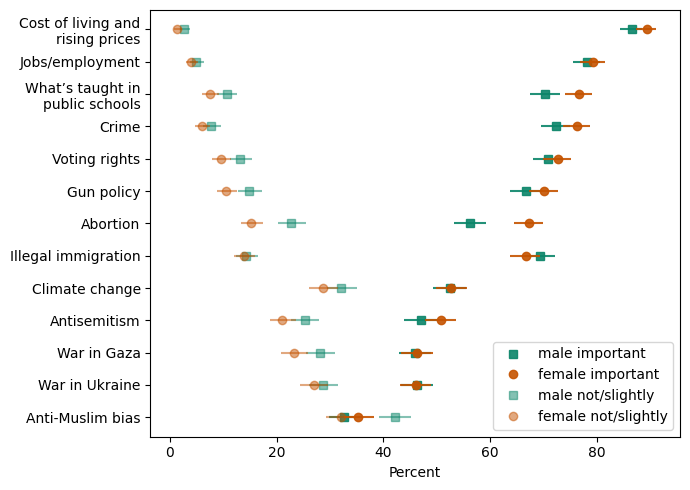

<IPython.core.display.Javascript object>

In [193]:
plt.figure(figsize=(7, 5))
plot_responses_by_gender(summary, "important", alpha=0.9)
plot_responses_by_gender(summary, "not/slightly", alpha=0.5)

## Pairwise compatibility

One way to interpret these results is to pick the ones with the biggest differences and talk about "wow the differences".
But these differences are often used to tell a story along the lines that men and women are becoming more politically incompatible, so I think it would be useful to quantify what we mean by compatible.

For example, if we imagine a speed-dating service that matches random women and men, and compares their responses, we could define a kind of compatibility score and see how often a hypothetical pair would find themselves disagreeing by too much on to many points.

We could calibrate the results by comparing them with male-male and female-female compatibility.

Here's a possible scoring function.
If you and another person assign the same level of importance to an issue, you get 2 points.
If you differ by 1 level, that's 0 points.
Differing by 2 levels costs 1 point, 3 levels costs 2 points, and four levels, which means you are at opposite ends of the range, costs 4 points.

In [142]:
score_map = {0: 2, 1: 0, 2: -1, 3: -2, 4: -4}
score_array = np.array(list(score_map.values()))

<IPython.core.display.Javascript object>

Spot check the first row from each group.

In [143]:
np.abs(data_male.iloc[0] - data_female.iloc[0]).replace(score_map).sum()

-3.0

<IPython.core.display.Javascript object>

The following function computes the total score across all issues for each pair of people in the two groups.

In [144]:
def pairwise_compatiblity(df1, df2):
    diffs = np.abs(df1.values[:, None, :] - df2.values[None, :, :])

    # replace missing values with 1,
    # which is a little bigger than the mean difference
    nan = np.isnan(diffs)
    diffs[nan] = 1

    return score_array[diffs.astype(int)].sum(axis=2)

<IPython.core.display.Javascript object>

Here's the compatibility array for men and women (and the spot check for the first pair).

In [145]:
compat_mf = pairwise_compatiblity(data_male, data_female)
compat_mf[0, 0]

-3

<IPython.core.display.Javascript object>

And here's the level of compatibility, averaged across all male-female pairs 

In [146]:
compat_mf.mean()

-0.1592337789154132

<IPython.core.display.Javascript object>

To put that in context, if you choose two women at random, they would be only slightly more politically compatible.

In [147]:
compat_ff = pairwise_compatiblity(data_female, data_female)
compat_ff.mean()

0.7411506560193556

<IPython.core.display.Javascript object>

And a random pair of men would be a bit less compatible.

In [148]:
compat_mm = pairwise_compatiblity(data_male, data_male)
compat_mm.mean()

-0.7984975118540287

<IPython.core.display.Javascript object>

However, these results vary from one resampling to another, so we would need to report them with error bars.

## Which Party Better Job

This section explores responses to a set of questions based on this schema:

>Please tell us which political party— the [Democrats/Republicans] or the [Republicans/Democrats]—would do a better job handling each of the following issues, or is there no difference.

```
Tabulation: Freq. Numeric Label
1 -7 No Answer
165 -1 inapplicable, legitimate skip
508 1 Democrats
780 2 Republicans
455 3 No difference
```

In [208]:
508 + 780 + 455

1743

<IPython.core.display.Javascript object>

In [210]:
columns = find_columns(df, "own_")

<IPython.core.display.Javascript object>

In [211]:
issue_names = {
    "own_immig": "Illegal immigration",
    "own_jobs": "Jobs/employment",
    "own_costliv": "Cost of living and\nrising prices",
    "own_climate": "Climate change",
    "own_abort": "Abortion",
    "own_gun": "Gun policy",
    "own_crime": "Crime",
    "own_gaza": "War in Gaza",
    "own_antisem": "Antisemitism",
    "own_votright": "Voting rights",
    "own_ukraine": "War in Ukraine",
    "own_schteach": "What’s taught in\npublic schools",
    "own_islamop": "Anti-Muslim bias",
}

<IPython.core.display.Javascript object>

In [212]:
value_counts(df["own_immig"])

,counts
values,
1.0,441
2.0,666
3.0,393


<IPython.core.display.Javascript object>

In [213]:
columns = issue_names.keys()
counts = value_count_frame(df, columns, normalize=True)
counts

,own_immig,own_jobs,own_costliv,own_climate,own_abort,own_gun,own_crime,own_gaza,own_antisem,own_votright,own_ukraine,own_schteach,own_islamop
-7.0,0.000,0.000000,0.000000,0.000000,0.000667,0.000000,0.000000,0.000000,0.000667,0.000000,0.001333,0.000000,0.000667
1.0,0.294,0.337333,0.309333,0.423333,0.442000,0.385333,0.266667,0.272667,0.310667,0.404000,0.349333,0.354000,0.363333
2.0,0.444,0.392667,0.400000,0.217333,0.290000,0.376667,0.399333,0.305333,0.258667,0.296667,0.280000,0.361333,0.188667
3.0,0.262,0.270000,0.290667,0.359333,0.267333,0.238000,0.334000,0.422000,0.430000,0.299333,0.369333,0.284667,0.447333


<IPython.core.display.Javascript object>

Most people answered all 13 questions, but a few answered 12 or 11.

In [214]:
data = df[columns].replace(-7, np.nan)
count = data.count(axis=1)
value_counts(count)

,counts
values,
11,1
12,3
13,1496


<IPython.core.display.Javascript object>

In [215]:
value_map = {"Democrats": [1], "Republicans": [2], "No Difference": [3]}
gender_map = dict(male=df_male, female=df_female)
summary = estimate_gender_map(df, columns, gender_map, value_map).sort_values(
    by=("male", "Republicans", "p")
)
summary

male                                               \
              Democrats                       Republicans              
                      p        low       high           p        low   
own_islamop    37.59521  34.691419  40.590991    21.24191  18.855643   
own_climate    46.89905  43.873886  49.947177   24.423595   21.90228   
own_antisem    32.75816  29.965425  35.678578   29.198709  26.507969   
own_ukraine   40.025936  37.081306  43.044427   29.961764  27.247508   
own_abort     46.713028  43.687984  49.762435   30.846289  28.104776   
own_votright   45.06462  42.055216  48.110572   31.354794  28.599961   
own_gaza      29.765801  27.057496  32.623946   31.632286  28.869725   
own_schteach  37.480616  34.581042    40.4729   38.522677   35.60363   
own_gun       39.977109  37.033264  42.995177   40.353977  37.404154   
own_jobs      38.097871  35.186589  41.097293   41.110651  38.149374   
own_crime     28.237016  25.577252  31.057943   41.221104  38.258216   
own_costliv   33.511813   30.69992  36.445807   41.600201  38.631902   
own_immig     31.896499  29.126687  34.800374   45.920854  42.903582   

                                                                female  \
                        No Difference                        Democrats   
                   high             p        low       high          p   
own_islamop    23.84144      41.16288  38.198783  44.192512   35.07321   
own_climate   27.134313     28.677355   26.00322  31.509391  39.659279   
own_antisem   32.043489     38.043131  35.132866   41.04194  30.021202   
own_ukraine   32.824409       30.0123   27.29652  32.876096  30.668799   
own_abort     33.729764     22.440683  20.001081  25.084547  43.476125   
own_votright  34.247701     23.580586  21.093482  26.263335  36.494404   
own_gaza      34.530866     38.601913  35.681444   41.60679  25.097698   
own_schteach  41.526718     23.996707  21.492544  26.693434  33.286087   
own_gun       43.375233     19.668914   17.35987  22.202569  37.267235   
own_jobs      44.137757     20.791478  18.427889  23.371366  32.053116   
own_crime     44.249003      30.54188  27.810362  33.417492  24.962201   
own_costliv   44.630704     24.887986  22.348407  27.613529   29.00159   
own_immig     48.968334     22.182647  19.755399  24.815892  28.257456   

                                                                      \
                                   Republicans                         
                    low       high           p        low       high   
own_islamop   32.304806  37.945872   16.679557  14.589797  19.002049   
own_climate   36.804254   42.58653   18.605599  16.412899  21.017577   
own_antisem   27.380515  32.801532   21.989047  19.636537   24.53734   
own_ukraine    28.00764  33.465274    24.48104  22.025056  27.115652   
own_abort     40.569285  46.428532   26.628336   24.09656  29.323354   
own_votright  33.696218  39.386923    26.85223  24.312747  29.553392   
own_gaza      22.620938  27.748392    28.37616  25.786432  31.116923   
own_schteach  30.559027  36.129887   32.268171  29.566657  35.093536   
own_gun       34.453976  40.169428   33.868318  31.127304  36.722006   
own_jobs      29.357189  34.874396   35.458171  32.681433  38.336479   
own_crime     22.490511  27.608772   36.575277  33.775477  39.468845   
own_costliv    26.39233  31.757516   37.263662   34.45047  40.165812   
own_immig     25.671505  30.995271   41.207882  38.329671  44.147503   

                                                  
             No Difference                        
                         p        low       high  
own_islamop      48.247233   45.30037  51.206339  
own_climate      41.735123  38.849696  44.678277  
own_antisem      47.989751  45.043329  50.950224  
own_ukraine      44.850161  41.925861  47.810508  
own_abort        29.895539  27.259429  32.672073  
own_votright     36.653366  33.852015  39.547938  
own_gaza         46.526142  43.590594  49.485953  
own_schteach     3

<IPython.core.display.Javascript object>

In [216]:
names = [issue_names[col] for col in summary.index]

<IPython.core.display.Javascript object>

For every issue, men are more likely to say that the Republicans handle it better.

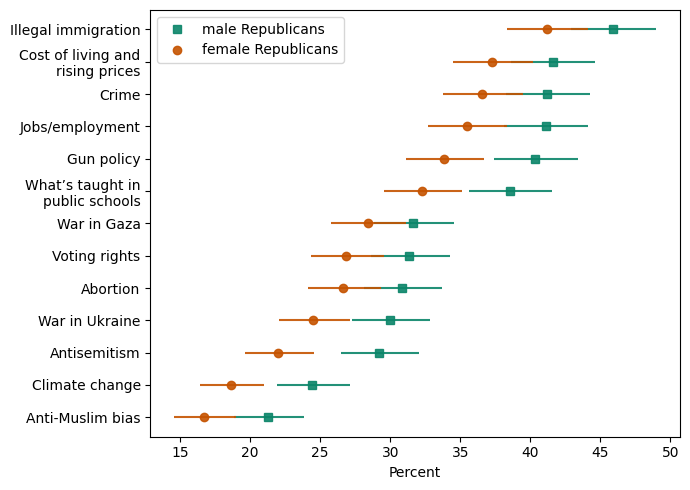

<IPython.core.display.Javascript object>

In [217]:
plt.figure(figsize=(7, 5))
plot_responses_by_gender(summary, "Republicans", alpha=0.9)

But they are also more likely to say that Democrats handle it better.

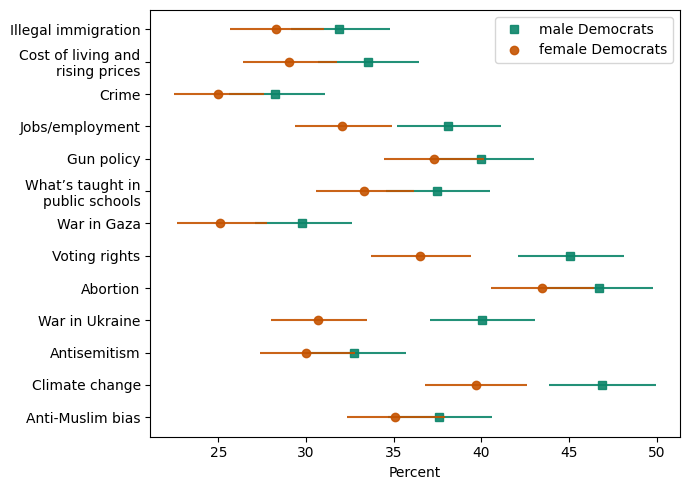

<IPython.core.display.Javascript object>

In [218]:
plt.figure(figsize=(7, 5))
plot_responses_by_gender(summary, "Democrats", alpha=0.9)

Because they are less likely to say that the two parties would handle it equally well -- which might mean that the respondent thinks the policies of the parties are the same, or might mean that they agree/disagree with the policies of the two parties by about the same amount. 

As an example of the latter, I recently heard an interview with a woman who was strongly opposed to abortion on religious grounds, but also in favor of legal access to abortion. Depending on her interpretation of R and D policies, she might consider herself equally at odds with both.

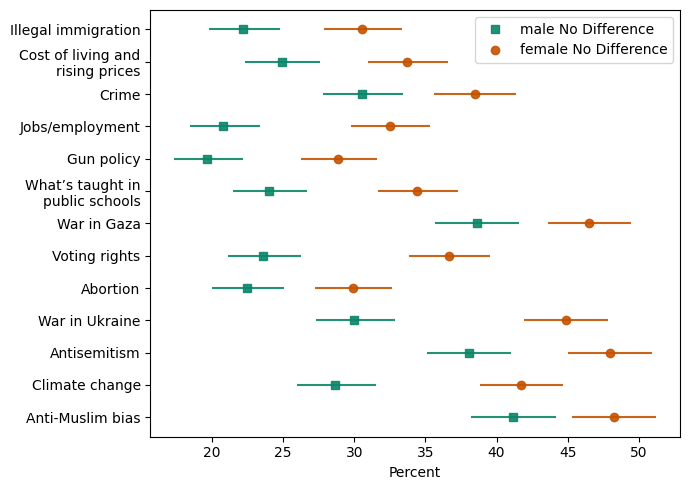

<IPython.core.display.Javascript object>

In [220]:
plt.figure(figsize=(7, 5))
plot_responses_by_gender(summary, "No Difference", alpha=0.9)

## Alignment with party


For each respondents, we add up the fraction of responses in each of the three categories, and the party they were more favorable toward. 

In [46]:
sample["dem"] = (data == 1).sum(axis=1) / count
sample["rep"] = (data == 2).sum(axis=1) / count
sample["no_diff"] = (data == 3).sum(axis=1) / count

sample["pref"] = "no diff"
sample.loc[sample["dem"] > sample["rep"], "pref"] = "dem"
sample.loc[sample["rep"] > sample["dem"], "pref"] = "rep"

sample[["dem", "rep", "no_diff", "pref"]].head()

,dem,rep,no_diff,pref
901,0.000000,0.000000,1.000000,no diff
246,0.000000,0.461538,0.538462,rep
1624,1.000000,0.000000,0.000000,dem
1005,0.615385,0.000000,0.384615,dem
1160,0.000000,0.692308,0.307692,rep


<IPython.core.display.Javascript object>

In [47]:
value_counts(sample["pref"])

,counts
values,
dem,877
no diff,258
rep,774


<IPython.core.display.Javascript object>

People who identify as Democrats are more likely to think the Democratic party handles these issues better, and people who identify as Republican are more likely to think the Republican party does -- but there are some exceptions in both directions, which might reflect data quality problems.

In [48]:
pd.crosstab(sample["pid"], sample["pref"])

pref,dem,no diff,rep
pid,,,
1.0,583,45,38
2.0,35,41,466
3.0,259,172,270


<IPython.core.display.Javascript object>

Here's the distribution of partisanship.

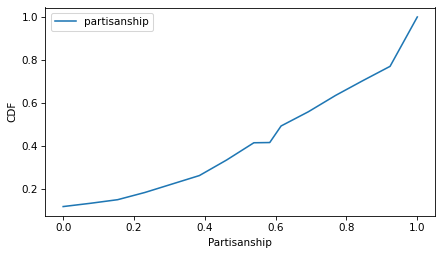

<IPython.core.display.Javascript object>

In [49]:
from empiricaldist import Cdf

sample["partisanship"] = sample[["dem", "rep"]].max(axis=1)
Cdf.from_seq(sample["partisanship"]).plot(label="partisanship")
decorate(xlabel="Partisanship", ylabel="CDF")

A score of 0 means the respondent said "no difference" to every questions. A score of 1 means they said that one party or the other handles every issue better.

In [50]:
sample_male = sample.query("gender == 1")
sample_female = sample.query("gender == 2")

<IPython.core.display.Javascript object>

Men are more partisan than women.

In [51]:
sample.groupby("gender")["partisanship"].mean()

gender
1.0    0.652994
2.0    0.584269
Name: partisanship, dtype: float64

<IPython.core.display.Javascript object>

If we break it down by gender and party identification, republicans are more partisan than democrats, independent/other are less partisan than both.


In [52]:
tab = sample.pivot_table(
    index="gender",
    columns="pid",
    values="partisanship",
    aggfunc="mean",
    margins=True,
)
tab.columns = ["dem", "rep", "ind/other", "all"]
tab.index = ["male", "female", "all"]
tab

,dem,rep,ind/other,all
male,0.695946,0.774327,0.531388,0.652994
female,0.671518,0.656944,0.431467,0.584269
all,0.682375,0.709788,0.481071,0.616238


<IPython.core.display.Javascript object>

Here are responses to "Some people don’t pay much attention to political campaigns.
How about you? Would you say that you have been [very much interested, somewhat
interested or not much interested/ not much interested, somewhat interested or very
much interested] in the political campaigns so far this year?"

```
1. Very much interested
2. Somewhat interested
3. Not much interested
```

In [53]:
value_counts(sample["follow_campinterest"])

,counts
values,
1.0,782
2.0,710
3.0,417


<IPython.core.display.Javascript object>

People who follow more closely are more partisan. The arrow of causation could go both ways there.

In [54]:
pd.crosstab(sample["gender"], sample["follow_campinterest"], normalize="index")

follow_campinterest,1.0,2.0,3.0
gender,,,
1.0,0.501126,0.356982,0.141892
2.0,0.330069,0.384917,0.285015


<IPython.core.display.Javascript object>

In [55]:
tab = sample.pivot_table(
    index="gender",
    columns="follow_campinterest",
    values="partisanship",
    aggfunc="mean",
    margins=True,
)
tab.columns = ["very", "somewhat", "not much", "all"]
tab.index = ["male", "female", "all"]
tab

,very,somewhat,not much,all
male,0.742264,0.642846,0.363248,0.652994
female,0.787491,0.599139,0.328840,0.584269
all,0.761755,0.618653,0.339236,0.616238


<IPython.core.display.Javascript object>

## Regression models

To put it all together, we'll run some regressions with partisanship as the dependent variable.

In [56]:
from statsmodels.iolib.table import SimpleTable


def display_summary(result):
    """Prints summary statistics from a regression model.

    result: RegressionResults object
    """
    params = result.summary().tables[1]
    display(params)

    if hasattr(result, "rsquared"):
        row = ["R-squared:", f"{result.rsquared:0.4}"]
    elif hasattr(result, "prsquared"):
        row = ["Pseudo R-squared:", f"{result.prsquared:0.4}"]
    else:
        return
    table = SimpleTable([row])
    display(table)

<IPython.core.display.Javascript object>

Women are less partisan.

In [57]:
import statsmodels.formula.api as smf

model = smf.ols('partisanship ~ C(gender)', data=sample).fit()
display_summary(model)


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.6530,0.011,58.409,0.000,0.631,0.675
C(gender)[T.2.0],-0.0687,0.015,-4.496,0.000,-0.099,-0.039


R-squared:,0.01049


<IPython.core.display.Javascript object>

Controlling for gender, republicans are (still) more partisan, independent/other are less.

In [58]:
import statsmodels.formula.api as smf

model = smf.ols('partisanship ~ C(gender) + C(pid)', data=sample).fit()
display_summary(model)


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.7261,0.015,49.485,0.000,0.697,0.755
C(gender)[T.2.0],-0.0787,0.015,-5.415,0.000,-0.107,-0.050
C(pid)[T.2.0],0.0270,0.018,1.474,0.141,-0.009,0.063
C(pid)[T.3.0],-0.2054,0.017,-11.992,0.000,-0.239,-0.172


R-squared:,0.1094


<IPython.core.display.Javascript object>

Controlling for level of interest in the campaign, the gender gap is cut by more than half.

I'd suggest that interest level is a mediator here -- part of the reason men are more partisan is that they follow the campaign more closely.

In [59]:
model = smf.ols('partisanship ~ C(gender) + C(pid) + C(follow_campinterest)', data=sample).fit()
display_summary(model)


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.8183,0.015,54.394,0.000,0.789,0.848
C(gender)[T.2.0],-0.0178,0.013,-1.328,0.184,-0.044,0.008
C(pid)[T.2.0],0.0060,0.017,0.361,0.718,-0.026,0.038
C(pid)[T.3.0],-0.1596,0.016,-10.181,0.000,-0.190,-0.129
C(follow_campinterest)[T.2.0],-0.1413,0.015,-9.474,0.000,-0.171,-0.112
C(follow_campinterest)[T.3.0],-0.3806,0.018,-21.161,0.000,-0.416,-0.345


R-squared:,0.2792


<IPython.core.display.Javascript object>

## Regressions

Let's run some regressions with number of "no difference" as the dependent variable.

In [66]:
sample["y"] = (sample[columns] == 3).sum(axis=1)
sample.groupby("gender")["y"].mean()

gender
1.0    3.786036
2.0    4.895201
Name: y, dtype: float64

<IPython.core.display.Javascript object>

The difference in means is 1.33

In [67]:
model = smf.ols('y ~ C(gender)', data=sample).fit()
display_summary(model)


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,3.7860,0.145,26.190,0.000,3.503,4.070
C(gender)[T.2.0],1.1092,0.198,5.611,0.000,0.721,1.497


R-squared:,0.01624


<IPython.core.display.Javascript object>

Part of that is "explained" by party id: women are less likely to identify as Republican, and  Republicans are less likely to say "no difference".

In [68]:
model = smf.ols('y ~ C(gender) + C(pid)', data=sample).fit()
display_summary(model)


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.8379,0.189,15.039,0.000,2.468,3.208
C(gender)[T.2.0],1.2431,0.187,6.654,0.000,0.877,1.610
C(pid)[T.2.0],-0.4513,0.235,-1.918,0.055,-0.913,0.010
C(pid)[T.3.0],2.7358,0.220,12.420,0.000,2.304,3.168


R-squared:,0.1242


<IPython.core.display.Javascript object>

And a little bit more is explained by following the campaign: women are less likely to follow, and people who follow are less likely to say "no difference" -- in fact, people who are "not much interested" say "no difference" much more -- the difference is 4.5.

In [69]:
model = smf.ols('y ~ C(gender) + C(pid) + C(follow_campinterest)', data=sample).fit()
display_summary(model)


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.7755,0.195,9.083,0.000,1.392,2.159
C(gender)[T.2.0],0.4987,0.174,2.866,0.004,0.157,0.840
C(pid)[T.2.0],-0.2095,0.215,-0.975,0.330,-0.631,0.212
C(pid)[T.3.0],2.1517,0.204,10.565,0.000,1.752,2.551
C(follow_campinterest)[T.2.0],1.5721,0.194,8.112,0.000,1.192,1.952
C(follow_campinterest)[T.3.0],4.6774,0.234,20.016,0.000,4.219,5.136


R-squared:,0.2765


<IPython.core.display.Javascript object>

## Group Ratings

This section explores reponses to questions that follow this schema:

> We would like to get your feelings toward some of our political leaders
and other people who are in the news these days. We will show the name of a person
and we’d like you to rate that person using something we call the feeling thermometer.
Ratings between 50 degrees and 100 degrees mean that you feel favorable and warm
toward the person. Ratings between 0 degrees and 50 degrees mean that you don’t feel
favorable toward the person and that you don’t care too much for that person. You
would rate the person at the 50 degree mark if you don’t feel particularly warm or cold
toward the person.
If we come to a person whose name you don’t recognize, you don’t need to rate that
person. Just click ’Next’ and we’ll move on to the next one.

In [70]:
columns = find_columns(sample, "cand_")
columns

['cand_trump', 'cand_biden']

<IPython.core.display.Javascript object>

In [71]:
sample[columns].replace(-7, np.nan).describe()

,cand_trump,cand_biden
count,1906.000000,1909.000000
mean,43.307975,41.665270
std,39.588621,36.390924
min,0.000000,0.000000
25%,1.000000,2.000000
50%,42.000000,40.000000
75%,84.000000,73.000000
max,100.000000,100.000000


<IPython.core.display.Javascript object>

In [72]:
sample_male = sample.query("gender == 1").replace(-7, np.nan)
sample_female = sample.query("gender == 2").replace(-7, np.nan)
len(sample_male), len(sample_female)

(888, 1021)

<IPython.core.display.Javascript object>

In [73]:
d = dict(male=sample_male[columns].mean(), female=sample_female[columns].mean())
ratings_df = pd.DataFrame(d).sort_values(by="female")
ratings_df

,male,female
cand_trump,45.172297,41.681729
cand_biden,41.384009,41.909892


<IPython.core.display.Javascript object>

In [74]:
def plot_ratings(summary, names):
    plt.hlines(
        names,
        summary["male"],
        summary["female"],
        color="gray",
        alpha=0.2,
    )

    draw_markers(summary['male'], names, 's', label='male')
    draw_markers(summary['female'], names, 'o', label='female')


<IPython.core.display.Javascript object>

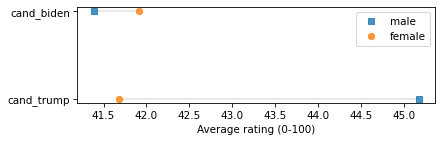

<IPython.core.display.Javascript object>

In [75]:
plt.figure(figsize=(6, 2))
names = ratings_df.index
plot_ratings(ratings_df, names)
decorate(xlabel="Average rating (0-100)")

In [76]:
columns = find_columns(sample, "group_")
columns

['group_maga',
 'group_demsoc',
 'group_fascists',
 'group_kkk',
 'group_nazi',
 'group_blm',
 'group_atheists',
 'group_prolife',
 'group_prochoice',
 'group_gunrights',
 'group_lgbtrights',
 'group_feminists',
 'group_whitesup',
 'group_antigay',
 'group_socialist',
 'group_antifa',
 'group_christfund',
 'group_laborun',
 'group_bigbus',
 'group_gayles',
 'group_transppl',
 'group_christians',
 'group_police',
 'group_journal',
 'group_nra',
 'group_ruralam',
 'group_planparent',
 'group_colprofs',
 'group_black',
 'group_white',
 'group_hispanic',
 'group_asian',
 'group_transmen',
 'group_transwom',
 'group_jews',
 'group_muslims']

<IPython.core.display.Javascript object>

In [77]:
sample[columns].replace(-7, np.nan).describe()

,group_maga,group_demsoc,group_fascists,group_kkk,group_nazi,group_blm,group_atheists,group_prolife,group_prochoice,group_gunrights,...,group_planparent,group_colprofs,group_black,group_white,group_hispanic,group_asian,group_transmen,group_transwom,group_jews,group_muslims
count,1903.000000,1907.000000,1898.000000,1899.000000,1905.000000,1909.000000,1909.000000,1909.000000,1907.000000,1907.000000,...,1909.000000,1905.000000,1909.000000,1908.000000,1909.000000,1908.000000,1909.000000,1909.000000,1909.000000,1909.000000
mean,37.214924,41.511799,17.394626,10.849921,12.561155,45.361446,46.080147,49.372446,55.420556,49.291033,...,57.742797,58.583202,70.298586,69.792977,69.281299,70.436059,43.342064,45.126244,69.272394,54.679413
std,34.499707,33.879923,23.779046,21.459991,21.887402,35.933045,30.526690,32.981081,32.752199,33.730301,...,34.714746,28.266839,25.367548,23.393750,24.429164,24.248746,34.169034,34.464856,24.770079,27.988896
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,4.000000,0.000000,0.000000,0.000000,5.000000,18.000000,16.000000,31.000000,16.000000,...,30.000000,45.000000,50.000000,50.000000,50.000000,50.000000,5.000000,7.000000,51.000000,43.000000
50%,36.000000,47.000000,3.000000,1.000000,1.000000,50.000000,50.000000,50.000000,54.000000,50.000000,...,61.000000,60.000000,72.000000,70.000000,70.000000,73.000000,50.000000,50.000000,70.000000,52.000000
75%,60.000000,70.000000,31.000000,7.000000,15.000000,76.000000,64.000000,75.000000,85.000000,78.000000,...,89.000000,84.000000,94.000000,90.000000,91.000000,90.000000,70.000000,72.000000,90.000000,74.000000
max,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


<IPython.core.display.Javascript object>

In [78]:
sample_male = sample.query("gender == 1").replace(-7, np.nan)
sample_female = sample.query("gender == 2").replace(-7, np.nan)
len(sample_male), len(sample_female)

(888, 1021)

<IPython.core.display.Javascript object>

In [79]:
d = dict(male=sample_male[columns].mean(), female=sample_female[columns].mean())
ratings_df = pd.DataFrame(d).sort_values(by="female")
ratings_df

,male,female
group_kkk,12.989796,8.994100
group_nazi,13.461105,11.777014
group_whitesup,17.055180,13.424510
group_fascists,17.559955,17.250493
group_antifa,29.144482,27.527638
group_antigay,31.561937,28.065686
group_maga,40.688209,34.214496
group_socialist,38.633596,40.216667
group_demsoc,39.719278,43.070588
group_nra,47.114865,43.490695


<IPython.core.display.Javascript object>

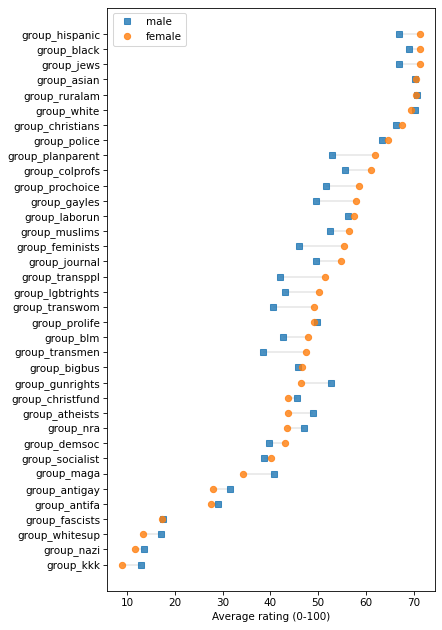

<IPython.core.display.Javascript object>

In [80]:
plt.figure(figsize=(6, 8.5))
names = ratings_df.index
plot_ratings(ratings_df, names)
decorate(xlabel="Average rating (0-100)")

## Look for variables with large gender gaps

This section and the next contain two methods for identifying questions with large gender gaps, without bothering to decode the responses.

Method 1 looks for variables where there's a big difference in the means, but it might not be reliable because a lot of variables are encoded in a way where the mean is not meaningful (or it's misleading).
But it's a way to find candidates.

Method 2 finds the most common response for each questions and looks at the differences in proportions of that response. It is more robust in the sense that it doesn't depend on the meaning of the responses, but it might miss differences in the less common responses.

In [81]:
def compute_diff_means(col, flag):
    male = df_male[col].dropna()
    try:
        male = male.where(male >= 0, np.nan)
    except TypeError:
        return np.nan

    female = df_female[col].dropna()
    female = female.where(female >= 0, np.nan)

    if male.count() == 0 or female.count() == 0:
        return np.nan

    m1, m2 = male.mean(), female.mean()
    avg = (m1 + m2) / 2
    return (m1 - m2) / avg

<IPython.core.display.Javascript object>

In [82]:
df_male = sample.query("gender == 1")
df_female = sample.query("gender == 2")
len(df_male), len(df_female)

(888, 1021)

<IPython.core.display.Javascript object>

In [83]:
df_male.dtypes

version          object
caseid            int16
weight          float64
weight_spss     float32
sample_type     float64
                 ...   
rep             float64
no_diff         float64
pref             object
partisanship    float64
y                 int64
Length: 948, dtype: object

<IPython.core.display.Javascript object>

In [84]:
candidate_cols = [
    col for col in df.columns if not col.endswith("timing") and not col.endswith("skp")
]

<IPython.core.display.Javascript object>

In [85]:
res = []
for col in candidate_cols:
    diff1 = compute_diff_means(col, True)
    diff2 = compute_diff_means(col, False)
    res.append((col, diff1, diff2))

<IPython.core.display.Javascript object>

In [86]:
columns = ["varname", "diff1", "diff2"]
diff_df = pd.DataFrame(res, columns=columns).dropna()

<IPython.core.display.Javascript object>

In [87]:
diff1 = diff_df["diff1"]
diff2 = diff_df["diff2"]
diff_df["absdiff"] = np.maximum(diff_df["diff1"].abs(), diff_df["diff2"].abs())

<IPython.core.display.Javascript object>

In [88]:
candidates = diff_df.sort_values(by="absdiff", ascending=False)
candidates.index = candidates["varname"]
candidates = candidates.drop(columns=["varname"]) * 100
candidates.head(50)

,diff1,diff2,absdiff
varname,,,
gendid_masc,112.101479,112.101479,112.101479
gendid_fem,-110.776025,-110.776025,110.776025
gendid_mascfem,-86.329280,-86.329280,86.329280
gender,-66.666667,-66.666667,66.666667
gender4,-64.953695,-64.953695,64.953695
rrace_resp_Eastern,57.142857,57.142857,57.142857
duration,-50.771042,-50.771042,50.771042
min_duration,-50.771042,-50.771042,50.771042
group_kkk,36.351114,36.351114,36.351114


<IPython.core.display.Javascript object>

In [89]:
candidates.to_csv("anes_2024_candidates_resampled.csv")

<IPython.core.display.Javascript object>

If you find a candidate, you can look more closely with `compare_responses`.

In [90]:
def compare_responses(varname):
    d = dict(
        male=value_counts(df_male[varname], normalize=True)["counts"],
        female=value_counts(df_female[varname], normalize=True)["counts"],
    )
    summary = pd.DataFrame(d)
    summary["diff"] = summary["male"] - summary["female"]
    summary["absdiff"] = summary["diff"].abs()
    return summary

<IPython.core.display.Javascript object>

In [91]:
compare_responses("pew_prayer") * 100

,male,female,diff,absdiff
values,,,,
1.0,20.495495,30.558276,-10.062781,10.062781
2.0,15.315315,14.495593,0.819723,0.819723
3.0,11.599099,9.402547,2.196553,2.196553
4.0,4.279279,2.252693,2.026586,2.026586
5.0,6.756757,7.051910,-0.295153,0.295153
6.0,14.752252,14.299706,0.452546,0.452546
7.0,25.000000,17.629775,7.370225,7.370225
8.0,1.801802,4.309500,-2.507699,2.507699


<IPython.core.display.Javascript object>

## Look for differences, method 2

Another way to look for differences, but finding the most common response to a question and then comparing the fractions who give that response.

In [92]:
def compute_diff(col):
    value = sample[col].value_counts().idxmax()

    male = df_male[col].dropna().value_counts()
    female = df_female[col].dropna().value_counts()

    p_male = male.get(value, 0) / male.sum()
    p_female = female.get(value, 0) / female.sum()
    return p_male - p_female

<IPython.core.display.Javascript object>

In [93]:
res = []
for col in candidate_cols:
    diff = compute_diff(col)
    res.append((col, diff))

<IPython.core.display.Javascript object>

In [94]:
columns = ["varname", "diff"]
diff_df = pd.DataFrame(res, columns=columns).dropna()
diff_df["absdiff"] = diff_df["diff"].abs()

<IPython.core.display.Javascript object>

In [95]:
candidates = diff_df.sort_values(by="absdiff", ascending=False)
candidates.index = candidates["varname"]
candidates = candidates.drop(columns=["varname"]) * 100
candidates.head(50)

,diff,absdiff
varname,,
gender,-100.000000,100.000000
gender4,-97.771903,97.771903
gendid_masc,-45.279535,45.279535
gendid_fem,43.776526,43.776526
gendid_mascfem,-37.718056,37.718056
follow_campinterest,17.105757,17.105757
newsint,15.802715,15.802715
disqual_sexhar,-14.887586,14.887586
poldisc_socmed_2,-13.634619,13.634619


<IPython.core.display.Javascript object>

In [96]:
candidates.to_csv("anes_2024_candidates_resampled.csv")

<IPython.core.display.Javascript object>